# Vector Light Fields in a High NA Objective

## Introduction

This work was completed as part of the Labratory Practices component of the Master's Degree in Photonics program at the University of Eastern Finland. The purpose of this project has been to investigate the field that is formed by the focusing of cyllindrical vector (CV) beams by an objective lens with a high numerical aperature (N.A.). This work follows from the theories which have been introduced by Dr. Qiwen Zhan in [Cylindrical vector beams: from mathematical concepts to applications](https://www.osapublishing.org/aop/fulltext.cfm?uri=aop-1-1-1&id=176226) and in particular focuses on using numerical methods for solving the integrals given as Eqs. 5.21-5.23.

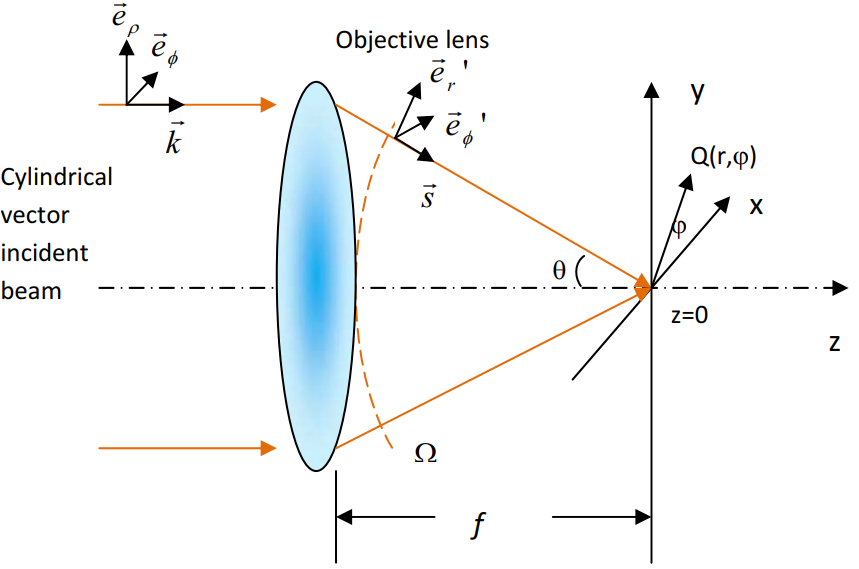

Where $\varphi_0$ is the ratio of radial to azumuthal polarization in the incident CV beam, $P(\theta)$ is the power of the beam as a funtion of $\theta$, $J_n$ is the Bessel function of the first kind and $n$th order, $k$ is the wavenumber which is related to the wavelength ($\lambda$) by $k = 2*\pi/\lambda$. $A$ is a collection of constants given by equation 5.15 as

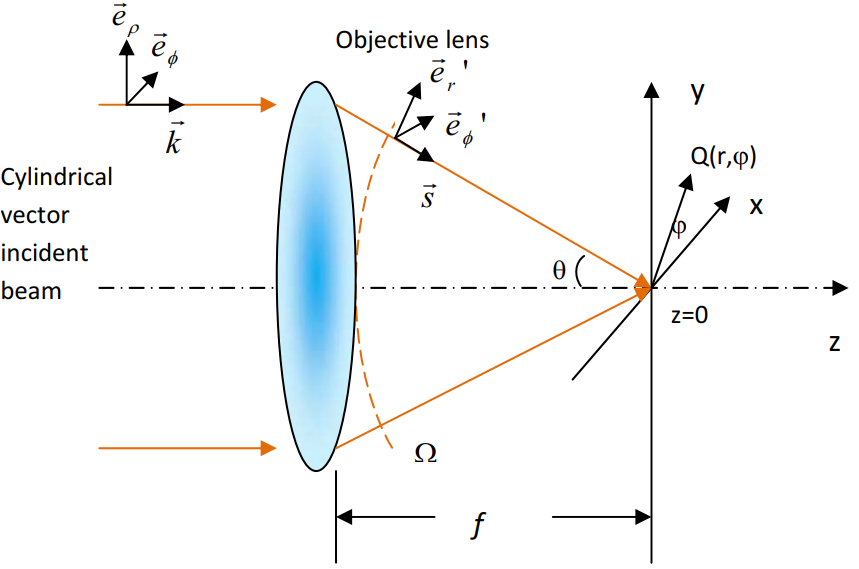

For a description of the cordinate system, please see the diagram below.

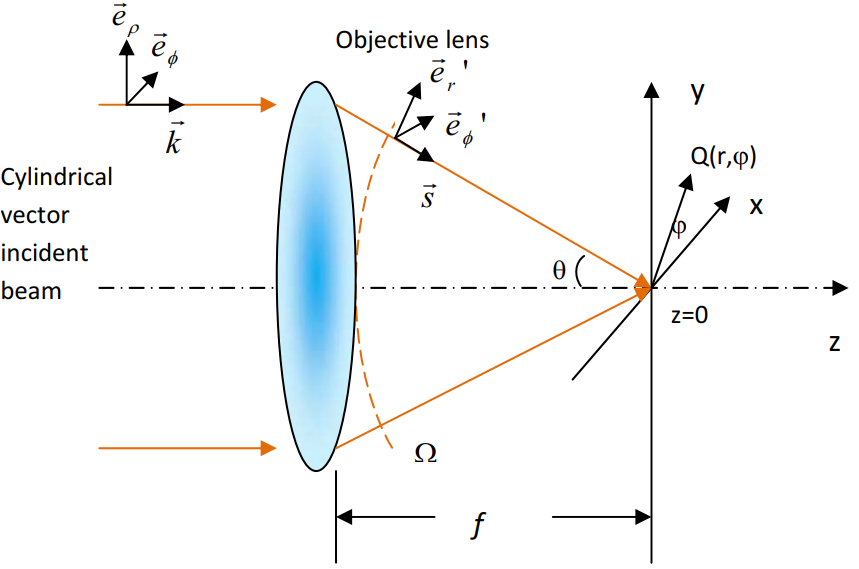

To stat building the simulation it is ofcourse necessary to first import the necessary libraries. I will be using the [quadpy](https://github.com/nschloe/quadpy) library here as it is more convenient for handling complex integrals (I hope that in a future updat I will find a way to permenantly load this library, however at the moment is is necessary to launch a terminal and use `pip install quadpy`). I am also using slightly different imports and notation than I would if I were simply writing this as I feel it improves the readability.

In [17]:
import numpy as np
from numpy import sqrt, arcsin, sin, cos, abs, exp, pi as π
from scipy.special import jv as J
import quadpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as mcolors

The next step will be to define constants and parameters as they were given by my research advisor for the project, Dr. Xiaorun Zang. This includes the wavelength $\lambda$ which I selected simply as the wavelength for Fraunhofer's D line, the focal length of 1000 µm, an $\text{N.A.}$ of 0.9. was suggested by Dr. Zang, the refractive index of the lens $n$ is conveniently set equal to $n_\text{air} \approx 1$, and for reasons that will be developed later the value $l_0$ (peak field amplitude) is set as 1 and polarization has been set to approximately 0. Finally, the variable `res` is used to control the "resolution" of the resulting plots and allows for faster simulations while testing, and more detailed images when desired.

In [18]:
λ = 0.5893 # μm. Chosen as the Frounhaufer D Line
f = 1000 # focal length of the objective in µm
NA = 0.9 #Given by prompt. XZ has said High NA > 0.6.
pol_angle = .0001 #Used to calculate varpi angle. 0-> full radial, 90 -> full azimuthal
n = 1 #Refractive index, here approximated for n_air
l_0 = 1 #Peak field amplitude
res = 50 #adjusting will affect plot details and run times

From these parameters it is now possible to begin solving the intermediate variables, including wavenumber, the range for $\theta$ (where the relation $\text{N.A.} = n\sin(\theta)$ is used to find the acceptance angle), $\varphi$ in radians, and $A$.

In [19]:
k = (2*π/λ)*n #wavenumber in the lens, vacuum wave number *  refractive index
θ_max = arcsin(NA) #angle of acceptance
θ = np.linspace(0, θ_max, res+1) #
𝜑_0 = pol_angle/180*π #defines incident polarization
A = π*f*l_0/λ

It is now necessary to consider the type of beam which is incident on the lens. The simplest case is arguably a Laguerre-Gaussian LG$_{00}$ mode, which follows the well know Gaussian distribution with radial symmetry. A simple lambda function allows for defining the power ($P$) of the beam as a function of $\theta$. The radius of the beam waist is defined to be the radius of the light gathering area of the lens as determined by the focal length and acceptance angle.

In [20]:
w = f*sin(θ_max) #radius of the beam waist
P = lambda θ: exp(-(f*sin(θ)/w)**2) # Gaussian beam, LG00 mode

Now lambda functions for each of the integrals can be defined in terms of $r$, $z$, $\theta$. This will allow for the solving of the field by integration across the range of $\theta$ for any point with cordinates $(r,z)$.

In [21]:
I_r = lambda θ,r,z: (P(θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_φ = lambda θ,r,z: (P(θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_z = lambda θ,r,z: (P(θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))


---

<center>From Here it is possible to skip to any of the following sections.</center>

---


It is now possibble to to perform the integration. The first step will be to define the area of interest in terms of $(x,y,z)$. This is done by establishing the range of $x$ and $y$ in terms of units of wavelngth at setting the $z$ cordinate to 0 (location of the focal point). Then using nested for loops to first solve for the $(r,z)$ cordinates and then calculating the integral at each each cordinate. This results in an a 2d array of datapoints for each function (which has been pre-allocated).

In [7]:
z = 0
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ

E_r = np.empty((len(xArray),len(yArray)), dtype = complex)
E_φ = np.empty((len(xArray),len(yArray)), dtype = complex)
E_z = np.empty((len(xArray),len(yArray)), dtype = complex)

for l in range(len(xArray)):
    for m in range(len(yArray)):
        r = sqrt(xArray[l]**2+yArray[m]**2)
        E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
        E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
        E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]

The intensity of the field is given by squaring the abosult value of the of the field, and is indicative of how the field will appear. Plotting the intensity is simply a matter of doing this for each point and using the matplotlib library to return the image. For reference the power function is also plotted.

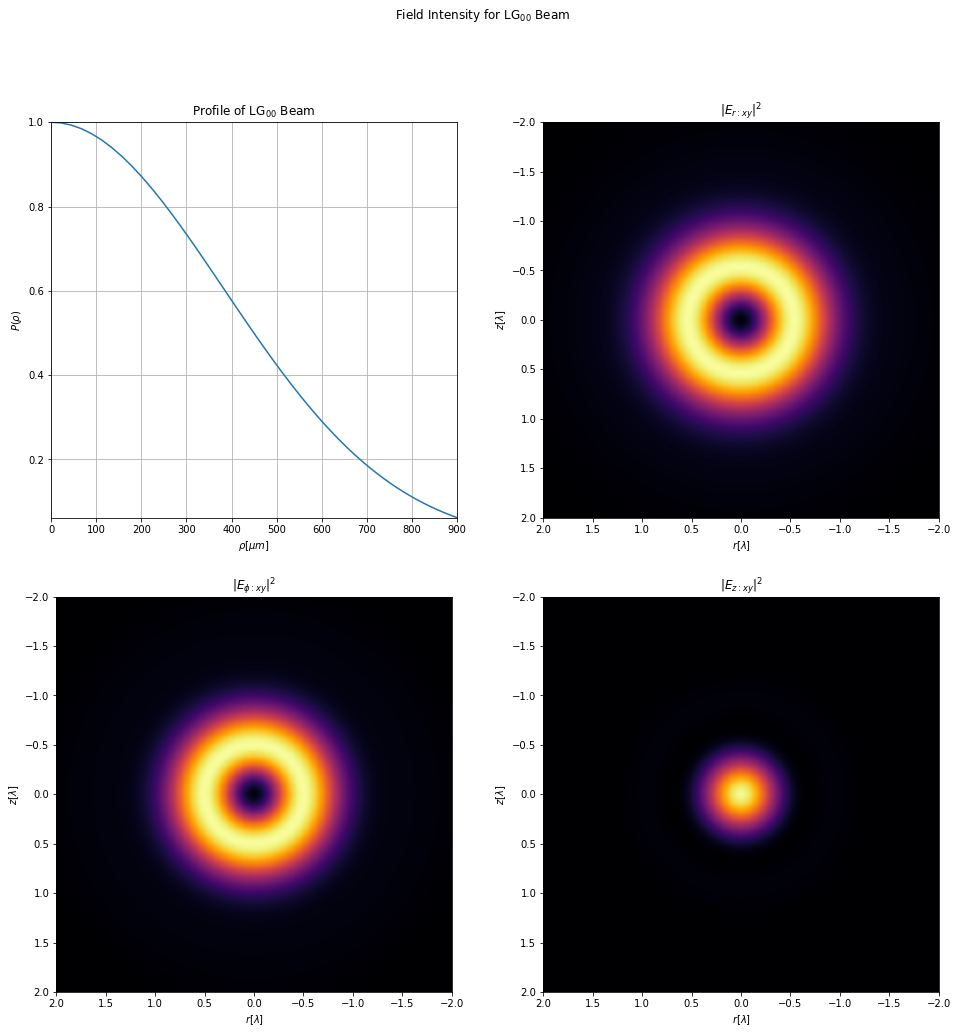

In [8]:
interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = [16, 16])
plt.suptitle('Field Intensity for LG$_{00}$ Beam')
axs[0,0].set(title = 'Profile of LG$_{00}$ Beam', xlabel = '$\\rho [\mu m]$',
           ylabel = '$P(\\rho)$', xlim = (0, f*.9), ylim = (np.min(P(θ)),1))
axs[0,0].plot(f*sin(θ),P(θ))
axs[0,0].grid()

axs[0,1].set(title = '$|E_{r:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[0,1].imshow(abs(E_r)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

axs[1,0].set(title = '$|E_{\phi:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,0].imshow(abs(E_φ)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

axs[1,1].set(title = '$|E_{z:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,1].imshow(abs(E_z)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

plt.show()

It is also possible to achieve a side ($rz$-plane) view of the field by varying $z$, and applying a similar series of steps.

In [9]:
np.min(P(θ))

0.06217652402211629

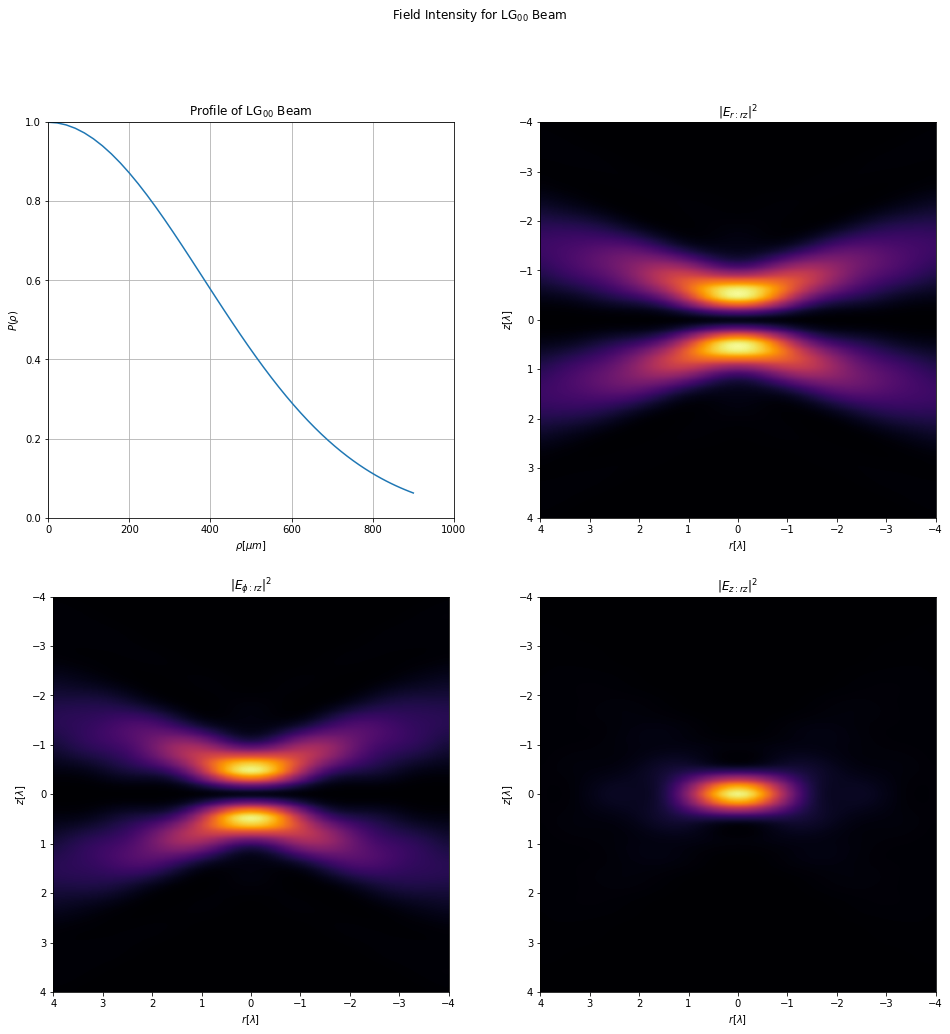

In [10]:
rArray = np.linspace(-4, 4, res)*λ 
zArray = np.linspace(-4, 4, res)*λ


for l in range(len(rArray)):
    for m in range(len(zArray)):
        z = zArray[m]
        r = rArray[l]
        E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
        E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
        E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]

r = rArray[0]/λ
z = zArray[0]/λ

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = [16, 16])
plt.suptitle('Field Intensity for LG$_{00}$ Beam')
axs[0,0].set(title = 'Profile of LG$_{00}$ Beam', xlabel = '$\\rho [\mu m]$',
           ylabel = '$P(\\rho)$', xlim = (0, f), ylim = (0,1))
axs[0,0].plot(f*sin(θ),P(θ))
axs[0,0].grid()

axs[0,1].set(title = '$|E_{r:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[0,1].imshow(abs(E_r)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

axs[1,0].set(title = '$|E_{\phi:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,0].imshow(abs(E_φ)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

axs[1,1].set(title = '$|E_{z:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,1].imshow(abs(E_z)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

plt.show()

## Variation of The Incident Beam Profile

There are a many ways that the conditions of the simulation may be adapted for other conditions. The first to be investigated will be the introduction of other types of beams. This is acheived by changing the $P(\theta)$ for other types of beams. Introducing the functions for a LG$_{01}$ Bessel-Gaussian beam.

(Duplicate original text, merge with above) First, the necessary values will be adjusted from base parameters which have already been difined. Three different beams will be tested in this simulation. The LG$_{00}$, and LG$_{10}$ modes of the Laguerre-Guassian $lm$ modes, and a Bessel-Gaussian which has been selected to have 3 distinct peaks. It will also be necessary to increase the plotted range for this set of simulations as the Bessel-Gaussian field requires a larger area of interest.

In [6]:
P = [lambda θ:exp(-(f*sin(θ)/w)**2), # LG00 profile
     lambda θ:(2*f/w*sin(θ))*exp((-(f*sin(θ)/w)**2))*sqrt(cos(θ))/np.max((2*f/w*sin(θ))*exp((-(f*sin(θ)/w)**2))*sqrt(cos(θ))),# LG10 profile
     lambda θ:((J(1, 1/36*f*sin(θ))*(exp((-(f*sin(θ)/w)**2)))*sqrt(cos(θ))))/np.max((J(1, 1/36*f*sin(θ))*(exp((-(f*sin(θ)/w)**2)))*sqrt(cos(θ))))] #Bessel profile given in handout

From here, all that is left is to perform the same series of integrations as before, and plot the results.

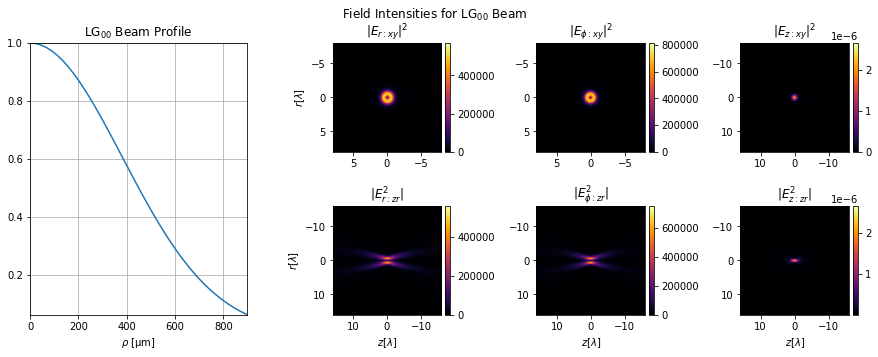

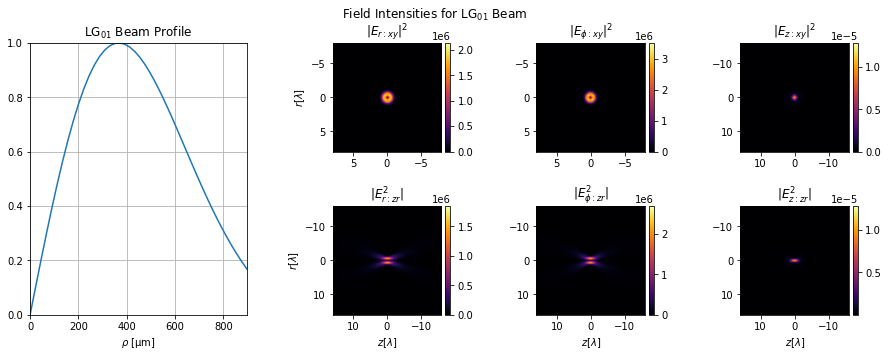

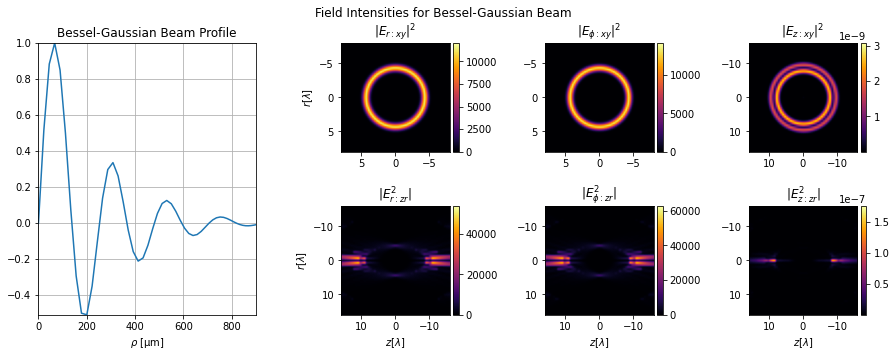

In [19]:
BeamResults = ['']*18
Titles = ['LG$_{00}$', 'LG$_{01}$', 'Bessel-Gaussian']

#A more 'zoomed out' view is convenient for viewing the Bessel-Gaussian case
xArray = np.linspace(-8, 8, res)*λ
yArray = np.linspace(-8, 8, res)*λ
rArray = np.linspace(-16, 16, res)*λ
zArray = np.linspace(-16, 16, res)*λ


#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((len(xArray),len(yArray)), dtype = complex)
E_φ = np.empty((len(xArray),len(yArray)), dtype = complex)
E_z = np.empty((len(xArray),len(yArray)), dtype = complex)

for i in range(len(P)):
    I_r = lambda θ,r,z: (P[i](θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
    I_φ = lambda θ,r,z: (P[i](θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
    I_z = lambda θ,r,z: (P[i](θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))

    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]
    
    BeamResults[6*i+0] = abs(E_r)**2 #Intensity of the E_r:xy field
    BeamResults[6*i+1] = abs(E_φ)**2 #Intensity of the E_φ:xy field
    BeamResults[6*i+2] = abs(E_z)**2 #Intensity of the E_z:xy field

    for l in range(len(rArray)):
        for m in range(len(zArray)):
            z = zArray[m]
            r = rArray[l]
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]

    BeamResults[6*i+3] = abs(E_r)**2 # Intensity of the E_r:rz field
    BeamResults[6*i+4] = abs(E_φ)**2 # Intensity of the E_φ:rz field
    BeamResults[6*i+5] = abs(E_z)**2 # Intensity of the E_z:rz field
    
    #Draw plots
    interp = 'gaussian'
    color = 'inferno'
    
    x = xArray[0]/λ
    y = yArray[0]/λ
    r = rArray[0]/λ
    z = zArray[0]/λ

    fields = plt.figure(figsize = [15,5])
    
    gs0 = gridspec.GridSpec(1, 2, width_ratios=[2, 5])
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    
    ax0 = plt.Subplot(fields, gs00[:, :])
    im0 = ax0.plot(f*sin(θ),P[i](θ))
    ax0.set(xlabel='$\\rho$ [μm]', title = Titles[i] + ' Beam Profile',
            xlim = (0, f*.9), ylim = (np.min(P[i](θ)),1))
    
    ax0.grid(), 
    fields.add_subplot(ax0)    

    
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1], 
                                            wspace = 0.5, hspace = 0.5)
    ax1 = plt.Subplot(fields, gs01[0, 0])
    
    im1 = ax1.imshow(BeamResults[6*i+0], cmap = color,
                     extent=[-x, x, -y, y], interpolation = interp)
    colorbar(im1)
    ax1.set_title('$|E_{r:xy}|^2$'), ax1.set_ylabel('$r [\lambda]$')
    fields.add_subplot(ax1)
    
    ax2 = plt.Subplot(fields, gs01[0, 1])
    im2 = ax2.imshow(BeamResults[6*i+1], cmap = color, 
                     extent=[-x, x, -y, y], interpolation = interp)
    colorbar(im2)
    ax2.set_title('$|E_{\phi:xy}|^2$')
    fields.add_subplot(ax2)
    
    ax3 = plt.Subplot(fields, gs01[0, 2])
    im3 = ax3.imshow(BeamResults[6*i+2], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im3)
    ax3.set(title='$|E_{z:xy}|^2$')
    fields.add_subplot(ax3)
    
    ax4 = plt.Subplot(fields, gs01[1, 0])
    im4 = ax4.imshow(BeamResults[6*i+3], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im4)
    ax4.set(title='$|E_{r:rz}|^2$', xlabel='$z [\lambda]$', 
            ylabel = '$r [\lambda]$')
    fields.add_subplot(ax4)
    
    ax5 = plt.Subplot(fields, gs01[1, 1])
    im5 = ax5.imshow(BeamResults[6*i+4], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im5)
    ax5.set(title='$|E_{\phi:rz}|^2$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax5)
    
    ax6 = plt.Subplot(fields, gs01[1, 2])
    im6 = ax6.imshow(BeamResults[6*i+5], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im6)
    ax6.set(title='$|E_{z:rz}|^2$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax6)
    
    plt.suptitle("Field Intensities for " + Titles[i] + " Beam")
    plt.show()

With the simulation complete, it is convenient to return to the initial parameters.

In [20]:
P = lambda θ: exp(-(f*sin(θ)/w)**2)

I_r = lambda θ,r,z: (P(θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_φ = lambda θ,r,z: (P(θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_z = lambda θ,r,z: (P(θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))

xArray = np.linspace(-2, 2, res+1)*λ
yArray = np.linspace(-2, 2, res+3)*λ
zArray = np.linspace(-4, 4, res+1)*λ
rArray = np.linspace(-4, 4, res+3)*λ

## Variation of Wavelength

The next parameter to be varied is the wavelength. An accepted range for the wavelengths in the optical spectrum is .4 μm to .8 μm. For this case the LG$_{00}$ mode is again used and three wavelengths are selected. Again the first step will be to change the parameters specific to this simimulation and pre allocate some memory or the results of the simulation.

In [22]:
Wavelengths = np.array([0.4, 0.6, 0.8])
WavFields = ['']*len(Wavelengths)

Adjusting which lines are commented out allows for the testing of any three wvelengths for any of the six planes that have been used.

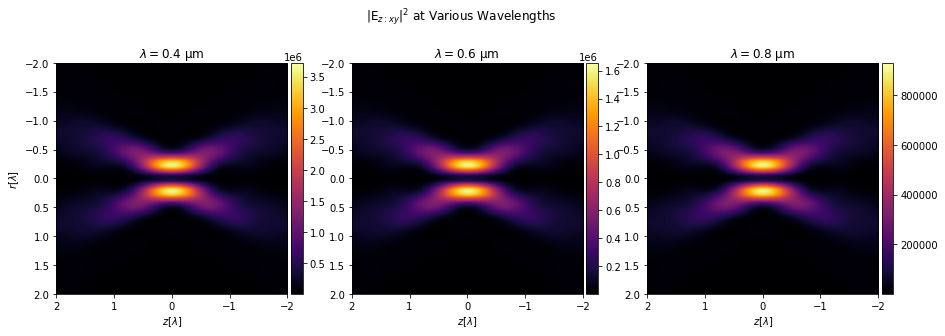

In [24]:
#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)

for i in range(len(Wavelengths)):
    λ = Wavelengths[i] # The i-th wavelength is selected
    k = 2*π/λ*n # A new wave number must be calculated
    A = π*f*l_0/λ # The wavelength is also part of the leading coeficient
    z=0
    
    #Of course as the coordinate system uses units of wavelength it must be adjusted as well
    xArray = np.linspace(-2, 2, res)*λ
    yArray = np.linspace(-2, 2, res)*λ
    rArray = np.linspace(-4, 4, res)*λ
    zArray = np.linspace(-4, 4, res)*λ
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]
    
#    WavFields[i] = np.abs(E_r)**2
#    WavFields[i] = np.abs(E_φ)**2
#    WavFields[i] = np.abs(E_z)**2
    
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
#            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
#            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]

    WavFields[i] = np.abs(E_r)**2
    #    WavFields[i] = np.abs(E_φ)**2
    #    WavFields[i] = np.abs(E_z)**2

interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ
r = rArray[0]/λ
z = zArray[0]/λ

WavField = plt.figure(figsize = [15, 5])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

plt.suptitle('|E$_{z:xy}|^2$ at Various Wavelengths')
ax0 = plt.Subplot(WavField, gs00[0, 0])
im0 = ax0.imshow(WavFields[0], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax0.set(title = '$\lambda = $' + str(Wavelengths[0]) + ' µm', 
        xlabel = '$z [\lambda]$', ylabel = '$r [\lambda]$')
WavField.add_subplot(ax0)
colorbar(im0)

ax1 = plt.Subplot(WavField, gs00[0, 1])
im1 = ax1.imshow(WavFields[1], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax1.set(title = '$\lambda = $' + str(Wavelengths[1]) + ' µm', 
        xlabel = '$z [\lambda]$')
WavField.add_subplot(ax1)
colorbar(im1)

ax2 = plt.Subplot(WavField, gs00[0, 2])
im2 = ax2.imshow(WavFields[2], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax2.set(title = '$\lambda = $' + str(Wavelengths[2]) + ' µm', 
        xlabel = '$z [\lambda]$')
WavField.add_subplot(ax2)
colorbar(im2)

From above it appears that the peak intensity of the the field in a given plane is higher for smaller wavelengths. While all three images appear to be the same, it is important to remember that the plots are in units of wavelength. This means that the in actuality the area of interest in the 0.4 µm case is a quarter the size (one half in both directions) of the 0.8 µm case. To investigate the wavelenghth-intensity relation a bit further, first the number of wavelengths are increased, and the peak intensity for the field in all six planes and each wavelength is plotted.

In [22]:
Wavelengths = np.linspace(0.4, 0.8, 11)
WavResults = np.empty([11,12])

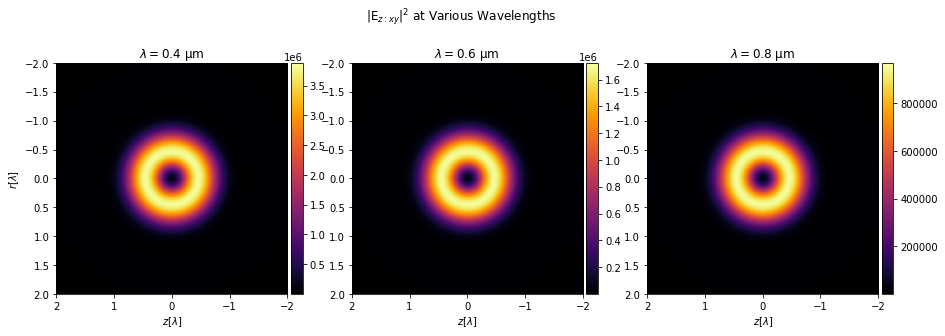

In [23]:
#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)

for i in range(len(Wavelengths)):
    λ = Wavelengths[i] # The i-th wavelength is selected
    k = 2*π/λ*n # A new wave number must be calculated
    A = π*f*l_0/λ # The wavelength is also part of the leading coeficient
    z=0
    
    #Of course as the coordinate system uses units of wavelength it must be adjusted as well
    xArray = np.linspace(-2, 2, res)*λ
    yArray = np.linspace(-2, 2, res)*λ
    rArray = np.linspace(-4, 4, res)*λ
    zArray = np.linspace(-4, 4, res)*λ
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]
    
    WavResults[i,1] = np.max(abs(E_r)**2)
    WavResults[i,2] = np.max(abs(E_φ)**2)
    WavResults[i,3] = np.max(abs(E_z)**2)
#    WavResults[i,7] = np.average(abs(E_r)**2)
#    WavResults[i,8] = np.average(abs(E_φ)**2)
#    WavResults[i,9] = np.average(abs(E_z)**2)
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*quadpy.quad(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2j*A*cos(𝜑_0)*quadpy.quad(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2*A*sin(𝜑_0)*quadpy.quad(lambda t: I_z(t,r,z), 0, θ_max)[0]

    WavResults[i,4] = np.max(abs(E_r)**2)
    WavResults[i,5] = np.max(abs(E_φ)**2)
    WavResults[i,6] = np.max(abs(E_z)**2)
#    WavResults[i,10] = np.average(abs(E_r)**2)
#    WavResults[i,11] = np.average(abs(E_φ)**2)
#    WavResults[i,12] = np.average(abs(E_z)**2)

interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ
r = rArray[0]/λ
z = zArray[0]/λ



Again it is convenient to return to the original parameters to keep the simulations modular.

In [ ]:
λ = 0.5893
k = 2*π/λ*n
coeff = l_0*k
A = π*f*l_0/λ

### Analysis of the Results

In [ ]:
#Plot Change in STD of Field Intensity for Wavelength 
xlabel = 'Wavelength [µm]'
ylabel = 'Std.'

WavStd = plt.figure(figsize = [15, 5])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = 0.5, wspace = 0.5)

plt.suptitle("Std. of Field Intensity with Variation in Wavelength")

ax0 = plt.Subplot(WavStd, gs00[0, 0])
im0 = ax0.plot(WavResults[0:11, 0], WavResults[0:11, 1])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
WavStd.add_subplot(ax0)

ax1 = plt.Subplot(WavStd, gs00[0, 1])
im1 = ax1.plot(WavResults[0:11, 0], WavResults[0:11, 2])
ax1.set(title='|E$_{\phi:xy}|^2$'), ax1.grid(), 
WavStd.add_subplot(ax1)

ax2 = plt.Subplot(WavStd, gs00[0, 2])
im2 = ax2.plot(WavResults[0:11, 0], WavResults[0:11, 3])
ax2.set(title='|E$_{z:xy}|^2$'), ax2.grid(), 
WavStd.add_subplot(ax2)

ax3 = plt.Subplot(WavStd, gs00[1, 0])
im3 = ax3.plot(WavResults[0:11, 0], WavResults[0:11, 4])
ax3.set(title='|E$_{r:rz}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
WavStd.add_subplot(ax3)

ax4 = plt.Subplot(WavStd, gs00[1, 1])
im4 = ax4.plot(WavResults[0:11, 0], WavResults[0:11, 5])
ax4.set(title='|E$_{\phi:rz}^2|$',  xlabel = xlabel), ax4.grid(), 
WavStd.add_subplot(ax4)

ax5 = plt.Subplot(WavStd, gs00[1, 2])
im5 = ax5.plot(WavResults[0:11, 0], WavResults[0:11, 6])
ax5.set(title='|E$_{z:rz}^2|$', xlabel = xlabel), ax5.grid(), 
WavStd.add_subplot(ax5)

#Plot Change in Std of Field Intensity for Wavelength 
xlabel = 'Wavelength [µm]'
ylabel = 'Average'

WavAvg = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = 0.5, wspace = 0.5)

plt.suptitle("Average Field Intensity with Variation in Wavelength")

ax0 = plt.Subplot(WavAvg, gs00[0, 0])
im0 = ax0.plot(WavResults[0:11, 0], WavResults[0:11, 7])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
WavAvg.add_subplot(ax0)

ax1 = plt.Subplot(WavAvg, gs00[0, 1])
im1 = ax1.plot(WavResults[0:11, 0], WavResults[0:11, 8])
ax1.set(title='|E$_{\phi:xy}|^2$'), ax1.grid(), 
WavAvg.add_subplot(ax1)

ax2 = plt.Subplot(WavAvg, gs00[0, 2])
im2 = ax2.plot(WavResults[0:11, 0], WavResults[0:11, 9])
ax2.set(title='|E$_{z:xy}|^2$'), ax2.grid(), 
WavAvg.add_subplot(ax2)

ax3 = plt.Subplot(WavAvg, gs00[1, 0])
im3 = ax3.plot(WavResults[0:11, 0], WavResults[0:11, 10])
ax3.set(title='|E$_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
WavAvg.add_subplot(ax3)

ax4 = plt.Subplot(WavAvg, gs00[1, 1])
im4 = ax4.plot(WavResults[0:11, 0], WavResults[0:11, 11])
ax4.set(title='|E$_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
WavAvg.add_subplot(ax4)

ax5 = plt.Subplot(WavAvg, gs00[1, 2])
im5 = ax5.plot(WavResults[0:11, 0], WavResults[0:11, 12])
ax5.set(title='|E$_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
WavAvg.add_subplot(ax5)

plt.show()

Observations

## Variation of Polarization

As always the first stup will be to setup the parameters which will be changing durng the simulation as well as prealocate the memory. For investigations into the affect of cahanges in polarization is is sensible to choose the range for $\varphi_0$ to be from  0$^\circ$ to 90$^\circ$. In other words from full radial polarization, to full azimuthal. One challenge to this is that at 0$^\circ$ the $E_r, E_z$ fields will go to zero and at 90$^\circ$ the $E_\phi$ field will go to 0. In the interest of being able to produce plots across the full range, these conditions have been approximated.

In [ ]:
PolResults = np.zeros([11,13])
PolResults[0:11, 0] = np.linspace(0.0001, 89.9999, 11)
PolFields = ['']*11
FieldResults = ['']*22

As before the simulation will be repeated eleven times with the data for the fields going into the PolFields array, and the standard deviation and sum of each of those fields going into the FieldResults array.

In [ ]:
for i in range(len(PolResults)):

    varphi0 = PolResults[i,0]/180*np.pi

    z=0

    phi = np.zeros((len(xArray),len(yArray)))
    I_phi2 = np.zeros((len(xArray),len(yArray)), dtype = complex)
    I_r2 = np.zeros((len(xArray),len(yArray)), dtype = complex)

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])
            phi[l,m] = (np.arctan2(yArray[m], xArray[l]))
 
            phi[l,m] = (np.arctan2(yArray[m], xArray[l]))
            I_phi2[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_r2[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])

    E_rxy = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phixy = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zxy = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    E_phixy2 = coeff*np.sin(varphi0)*np.real_if_close(I_phi2)
    E_rxy2 = coeff*np.cos(varphi0)*np.real_if_close(I_r2)
    FieldResults[2*i+0] = np.cos(phi)*E_rxy2-np.sin(phi)*E_phixy2#Ex
    FieldResults[2*i+1] = np.sin(phi)*E_rxy2+np.cos(phi)*E_phixy2#Ey
    
    for l in range(len(zArray)):
        z = zArray[l]

        for m in range(len(rArray)):
            r = rArray[m]
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rrz = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phirz = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zrz = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    PolFields[i] = np.abs(E_rxy)**2
    
    PolResults[i,1] = np.std(np.abs(E_rxy)**2)
    PolResults[i,2] = np.std(np.abs(E_phixy)**2)
    PolResults[i,3] = np.std(np.abs(E_zxy)**2)
    PolResults[i,4] = np.std(np.abs(E_rrz)**2)
    PolResults[i,5] = np.std(np.abs(E_phirz)**2)
    PolResults[i,6] = np.std(np.abs(E_zrz)**2)
    PolResults[i,7] = np.average(np.abs(E_rxy)**2)
    PolResults[i,8] = np.average(np.abs(E_phixy)**2)
    PolResults[i,9] = np.average(np.abs(E_zxy)**2)
    PolResults[i,10] = np.average(np.abs(E_rrz)**2)
    PolResults[i,12] = np.average(np.abs(E_phirz)**2)
    PolResults[i,11] = np.average(np.abs(E_zrz)**2)

Before moving forward the variables are reurned to their standard values.

In [ ]:
pol_angle = .0001
varphi0 = pol_angle/180*np.pi

### Plotting of the Results

Again representative plots of $|\textbf{E}_{r:xy}|^2$ are created in order to get an idea of the affect that these changes had.

In [ ]:
for i in range(3):
    PolField = plt.imshow(PolFields[i*5], cmap = 'inferno', 
                         extent=[-x, x, -y, y], 
                                 interpolation = interp)
    colorbar(PolField)
    plt.title('|E$_{r:xy}|^2$') 
    plt.ylabel('$r [\lambda]$')
    plt.xlabel('$z [\lambda]$')
    plt.show()

As may have been expected the affect to the polarization is that the field here is high for the fully radial 0$^\circ$ condition and much lower for the fully azimuthal 90$^\circ$ condition. It may also be observed that the field is not spreading out as was the case when \lambda had been varied. To further investigate this, again the standard deviation of the field is again plotted.

In [ ]:
#Plot Change in Std of Field Intensity for Polarization 
xlabel = 'Angle [$^\circ$]'
ylabel = 'Std.'

PolStd = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Std. of Field Intensity with Variation in Polarization")

ax0 = plt.Subplot(PolStd, gs00[0, 0])
im0 = ax0.plot(PolResults[0:11, 0], PolResults[0:11, 1])
ax0.set(title='$|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
PolStd.add_subplot(ax0)

ax1 = plt.Subplot(PolStd, gs00[0, 1])
im1 = ax1.plot(PolResults[0:11, 0],PolResults[0:11, 2])
ax1.set(title='$|E$_{\phi:xy}|^2$'), ax1.grid(), 
PolStd.add_subplot(ax1)

ax2 = plt.Subplot(PolStd, gs00[0, 2])
im2 = ax2.plot(PolResults[0:11, 0],PolResults[0:11, 3])
ax2.set(title='$|E$_{z:xy}|^2$'), ax2.grid(), 
PolStd.add_subplot(ax2)

ax3 = plt.Subplot(PolStd, gs00[1, 0])
im3 = ax3.plot(PolResults[0:11, 0],PolResults[0:11, 4])
ax3.set(title='$|E$_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
PolStd.add_subplot(ax3)

ax4 = plt.Subplot(PolStd, gs00[1, 1])
im4 = ax4.plot(PolResults[0:11, 0],PolResults[0:11, 5])
ax4.set(title='$|E$_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
PolStd.add_subplot(ax4)

ax5 = plt.Subplot(PolStd, gs00[1, 2])
im5 = ax5.plot(PolResults[0:11, 0],PolResults[0:11, 6])
ax5.set(title='$|E$_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
PolStd.add_subplot(ax5)

This shows that the main result of the change in incident poloarization is that the energy will become focused to certain planes. This result follows the aformentioned intuitive result based on the value of $\cos \varphi_0$, and $\sin \varphi_0$. It also seems prudent to investigate it the lens had any affect on the polarization of the field. To do this quiver plots are generated for the polarization at the same representative values as before.

In [ ]:
#Plot Transverse Field in Focal Plane
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [9, 3])
[X,Y] = np.meshgrid(xArray/Lambda, yArray/Lambda)
step = 4
plt.subplots_adjust(top=.85)
plt.suptitle('Plarization in the Focal Region for Various Incident Polarizations ($\Re[\\textbf{E}_x,\\textbf{E}_y])$')

axs[0].set(title='Full Radial ($\\varphi \\approx \SI{0}{\degree}$)', xlabel='z $[\lambda]$', ylabel = 'r $[\lambda]$')
axs[0].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[0]))[::step, ::step], 
              np.real(np.transpose(FieldResults[1]))[::step, ::step])

axs[1].set(title='Equal Polarization ($\\varphi = \SI{45}{\degree}$)', xlabel='z $[\lambda]$')
axs[1].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[8]))[::step, ::step], 
              np.real(np.transpose(FieldResults[9]))[::step, ::step])

axs[2].set(title='Full Azimuthal ($\\varphi \\approx \SI{90}{\degree}$)', xlabel='z $[\lambda]$')
axs[2].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[-2]))[::step, ::step], 
              np.real(np.transpose(FieldResults[-1]))[::step, ::step])
plt.show()

## Variations of Numerical Aperature

Change variables, prealocate memory

In [ ]:
NAResults = np.zeros([11,13])
NAResults[0:11, 0] = np.linspace(0.6, 0.9, 11)
NAFields = ['']*11

Run the simulation

In [ ]:
for i in range(len(NAResults)):
    NA = NAResults[i,0]
    theta_max = np.arcsin(NA)
    theta = np.linspace(0,theta_max,201)
    w = 0.4*f*np.sin(theta_max)

    z=0

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rxy = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phixy = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zxy = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    for l in range(len(zArray)):
        z = zArray[l]

        for m in range(len(rArray)):
            r=rArray[m]
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rrz = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phirz = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zrz = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    NAFields[i] = np.abs(E_rxy)**2
    
    NAResults[i,1] = np.std(np.abs(E_rxy)**2)
    NAResults[i,2] = np.std(np.abs(E_phixy)**2)
    NAResults[i,3] = np.std(np.abs(E_zxy)**2)
    NAResults[i,4] = np.std(np.abs(E_rrz)**2)
    NAResults[i,5] = np.std(np.abs(E_phirz)**2)
    NAResults[i,6] = np.std(np.abs(E_zrz)**2)
    NAResults[i,7] = np.sum(np.abs(E_rxy)**2)
    NAResults[i,8] = np.sum(np.abs(E_phixy)**2)
    NAResults[i,9] = np.sum(np.abs(E_zxy)**2)
    NAResults[i,10] = np.sum(np.abs(E_rrz)**2)
    NAResults[i,11] = np.sum(np.abs(E_phirz)**2)
    NAResults[i,12] = np.sum(np.abs(E_zrz)**2)

Return to orgiginal parameters

In [ ]:
NA = 0.9

### Plot the Results

Three representative plots

In [ ]:
for i in range(3):
    NAField = plt.imshow(NAFields[i*5], cmap = 'inferno', 
                         extent=[-x, x, -y, y], 
                                 interpolation = interp)
    colorbar(NAField)
    plt.title('$|\\textbf{E}_{r:xy}|^2$') 
    plt.ylabel('$r [\lambda]$')
    plt.xlabel('$z [\lambda]$')
    plt.show()

Analysis of the plots, and reasoning for next investigation.

In [ ]:
xlabel = '$N.A.$'
ylabel = 'Std.'

NAStd = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Std. of Field Intensity with Varying $N.A.$")

ax0 = plt.Subplot(NAStd, gs00[0, 0])
im0 = ax0.plot(NAResults[0:11, 0],NAResults[0:11, 1])
ax0.set(title='$|\\textbf{E}_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
NAStd.add_subplot(ax0)

ax1 = plt.Subplot(NAStd, gs00[0, 1])
im1 = ax1.plot(NAResults[0:11, 0],NAResults[0:11, 2])
ax1.set(title='$|\\textbf{E}_{\phi:xy}|^2$'), ax1.grid(), 
NAStd.add_subplot(ax1)

ax2 = plt.Subplot(NAStd, gs00[0, 2])
im2 = ax2.plot(NAResults[0:11, 0],NAResults[0:11, 3])
ax2.set(title='$|\\textbf{E}_{z:xy}|^2$'), ax2.grid(), 
NAStd.add_subplot(ax2)

ax3 = plt.Subplot(NAStd, gs00[1, 0])
im3 = ax3.plot(NAResults[0:11, 0],NAResults[0:11, 4])
ax3.set(title='$|\\textbf{E}_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
NAStd.add_subplot(ax3)

ax4 = plt.Subplot(NAStd, gs00[1, 1])
im4 = ax4.plot(NAResults[0:11, 0],NAResults[0:11, 5])
ax4.set(title='$|\\textbf{E}_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
NAStd.add_subplot(ax4)

ax5 = plt.Subplot(NAStd, gs00[1, 2])
im5 = ax5.plot(NAResults[0:11, 0],NAResults[0:11, 6])
ax5.set(title='$|\\textbf{E}_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
NAStd.add_subplot(ax5)

Analyze the results and justify next investigation.

In [ ]:
volResults = np.zeros([len(NAResults)])
ratResults = np.zeros([len(NAResults),2])
for i in range(len(NAResults)):
    NA = NAResults[i,0]
    theta_max = np.arcsin(NA)
    theta = np.linspace(0,theta_max,201)
    w = 0.4*f*np.sin(theta_max)
    volResults[i] = quadpy.quad(lambda theta: 2*np.pi*theta*np.exp(-(f*np.sin(theta)/w)**2), 0, theta_max)[0]
    ratResults[i] = NAResults[i, 1]/volResults[i], NAResults[i, 7]/volResults[i]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [9, 3])
plt.subplots_adjust(top = .85)
plt.suptitle('Comparison of Beam Volume to SD and Sum Intensity of Field Intensity')

axs[0].set(title='Volume of the Beam', xlabel='$N.A.$', )
axs[0].plot(NAResults[0:11, 0], volResults), axs[0].grid()

axs[1].set(title='Standard Deviation', xlabel='$N.A.$')
axs[1].plot(NAResults[0:11, 0], ratResults[0:11,0]), axs[1].grid()

axs[2].set(title='Sum Intensity', xlabel='$N.A.$')
axs[2].plot(NAResults[0:11, 0], ratResults[0:11, 1]), axs[2].grid()

plt.savefig(fname = 'NAVol', bbox_inches = 'tight')
plt.savefig(fname = 'NAVol.pdf', bbox_inches = 'tight', format = 'pdf')
plt.show()

Analyze results

## Conclusions

Conclusions

In order to help keep all of the following simulations modular, a few things related to plotting are defined. Code for keeping the color bars in place, and illustradted better was borrowed from Joseph Longs article on fixing color bars [https://joseph-long.com/writing/colorbars/] In order to create plots with  customized color maps code was borrowed from Kerry Halupka [https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72]

In [11]:
interp = 'gaussian'
space = 0.5

#x = xArray[0]/Lambda
#y = yArray[0]/Lambda
#z = zArray[0]/Lambda
#r = rArray[0]/Lambda

#Code borrowed from Joseph Long
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

def hex_to_rgb(value):

    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):

    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp